In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from perceiver_basic import model
from torch.utils.data import DataLoader
from collections.abc import Iterable

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FMPreprocess(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.shape = (1, 20, 20)
        self.encoding = self._generate_encoding()
        self.encoding = torch.nn.Parameter(self.encoding)
        self.encoding.requires_grad = False
        
        self.conv0 = torch.nn.Conv2d(1, 8, kernel_size=9, stride=1, bias=False)

    def _generate_encoding(self):
        dims = len(self.shape)-1 #minus batch dim
        encoding = torch.zeros([*self.shape, dims])
        for i in range(encoding[0].shape[0]):
            for j in range(encoding[0].shape[1]):
                encoding[0,i,j][0] = i * 2.0 / encoding[0].shape[0] - 1.0
                encoding[0,i,j][1] = i * 2.0 / encoding[0].shape[0] - 1.0
        return encoding

    def forward(self, in_val):
        x = in_val
        x = x.view([-1, 1, 28, 28])
        x = self.conv0(x)
        x = x.permute([0,3,2,1])
        #print(x.shape)
        batch_count = in_val.shape[0]
        dims = [-1 for _ in range(len(self.encoding.shape))]
        dims[0] = batch_count
        encoding = self.encoding.expand(*dims)
        x = torch.cat([x, encoding], dim=-1) #concatenating positional encodings
        #x = torch.mul(x, encoding) #scaled positional encoding
        
        #maintain batch and pixel codes, pixels will be in sequential form
        x = torch.flatten(x, start_dim=1, end_dim=-2)

        return x

In [6]:
pre = FMPreprocess()
print(len(list(pre.parameters())))
garbo = torch.randn([5, 28, 28])
pre(garbo).shape

2


torch.Size([5, 400, 10])

In [7]:
imp.reload(model)
class PerceiverClassify(torch.nn.Module):
    def __init__(self, latent_dim, heads, wide_factor, latent_count, repeat_count=1, p_dropout=0.1):
        super().__init__()
        self.preprocess = FMPreprocess()
        out_dim = (8,8)
        #in_channels = len(self.preprocess.shape) #subtract one for batch dim, but add one for the pixel dim
        in_channels = 10
        self.perceiver = model.PerceiverInternal(in_channels, latent_dim, out_dim, heads, wide_factor, latent_count, repeat_count, p_dropout)
        
        self.lin_out = torch.nn.Linear(64, 10)
        self.softmax = torch.nn.Softmax(-1)
        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        #x = x / self.range
        x = self.preprocess(x)

        x = self.perceiver(x)
      
        # x.shape <- (batch_count, 1, 32)
        #x = x.squeeze()
        x = self.flatten(x)
        x = self.lin_out(x)
        x = self.softmax(x)

        return x

In [8]:
class GarbageNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.garbo = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(-1),
        )
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.garbo(x)
        return x

In [9]:
per = PerceiverClassify(latent_dim=(32, 32), heads=8, wide_factor=4, latent_count=1)
garbo = torch.randn([1, 28, 28])
per(garbo).shape

torch.Size([1, 10])

In [10]:
mh = torch.nn.MultiheadAttention(32, 8, vdim=7, kdim=7, batch_first=True)
q = torch.randn([3, 2, 32])
kv = torch.randn([3, 6, 7])
mh(q, kv, kv)[0].shape

torch.Size([3, 2, 32])

In [11]:
BATCH_SIZE = 32
EPOCHS = 10

In [12]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST('./fm_set', transform=transforms, download=True)
testset = torchvision.datasets.FashionMNIST('./fm_set', train=False, transform=transforms, download=True)

In [13]:
torch.max(dataset[0][0])

tensor(1.)

In [14]:
dataloader = DataLoader(dataset, num_workers=2, batch_size=BATCH_SIZE)

In [24]:
perceiver = PerceiverClassify(latent_dim=(16,16), heads=8, wide_factor=6, latent_count=16)
# perceiver = GarbageNet()
perceiver.to(device)
optimizer = torch.optim.Adam(perceiver.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [25]:
garbo = torch.randn([3, 28, 28])
garbo = garbo.to(device)
perceiver(garbo).shape

torch.Size([3, 10])

In [26]:
def get_grad(x):
    if x.grad != None:
        grad = x.grad.detach().cpu()
        
    return -69

In [27]:
torch.tensor([1]).shape

torch.Size([1])

In [28]:
def ret_grad_list(params):
    if isinstance(params, torch.Tensor) and len(params.shape) == 0:
        return [params.grad]
    garbo = [ret_grad_list(param) for param in params]
    product = []
    for garb in garbo:
        product += garb
    return product

In [29]:
paramsInit = [t.clone() for t in perceiver.parameters()]

Entering epoch 0
Iteration - 0 - loss 2.317038059234619
Iteration - 1 - loss 2.304450035095215
Iteration - 2 - loss 2.300858736038208
Iteration - 3 - loss 2.3018834590911865
Iteration - 4 - loss 2.3079569339752197
Iteration - 5 - loss 2.3000071048736572
Iteration - 6 - loss 2.3090312480926514
Iteration - 7 - loss 2.3030667304992676
Iteration - 8 - loss 2.3010106086730957
Iteration - 9 - loss 2.297578811645508
Iteration - 10 - loss 2.3051607608795166
Iteration - 11 - loss 2.300846576690674
Iteration - 12 - loss 2.3062429428100586
Iteration - 13 - loss 2.296564817428589
Iteration - 14 - loss 2.3100247383117676
Iteration - 15 - loss 2.297247886657715
Iteration - 16 - loss 2.2957029342651367
Iteration - 17 - loss 2.3088133335113525
Iteration - 18 - loss 2.303401470184326
Iteration - 19 - loss 2.313279390335083
Iteration - 20 - loss 2.3098461627960205
Iteration - 21 - loss 2.30597186088562
Iteration - 22 - loss 2.3037424087524414
Iteration - 23 - loss 2.2977895736694336
Iteration - 24 - los

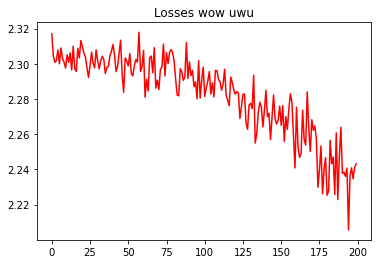

Iteration - 200 - loss 2.2382044792175293
Iteration - 201 - loss 2.2347805500030518
Iteration - 202 - loss 2.249570369720459
Iteration - 203 - loss 2.2191293239593506
Iteration - 204 - loss 2.2223544120788574
Iteration - 205 - loss 2.2306411266326904
Iteration - 206 - loss 2.22845196723938
Iteration - 207 - loss 2.1928794384002686
Iteration - 208 - loss 2.215200662612915
Iteration - 209 - loss 2.2374279499053955
Iteration - 210 - loss 2.2743780612945557
Iteration - 211 - loss 2.231473922729492
Iteration - 212 - loss 2.231142044067383
Iteration - 213 - loss 2.2190983295440674
Iteration - 214 - loss 2.2096400260925293
Iteration - 215 - loss 2.2044677734375
Iteration - 216 - loss 2.1874895095825195
Iteration - 217 - loss 2.220508098602295
Iteration - 218 - loss 2.1761374473571777
Iteration - 219 - loss 2.2181098461151123
Iteration - 220 - loss 2.1953635215759277
Iteration - 221 - loss 2.2235326766967773
Iteration - 222 - loss 2.2318167686462402
Iteration - 223 - loss 2.2109768390655518
It

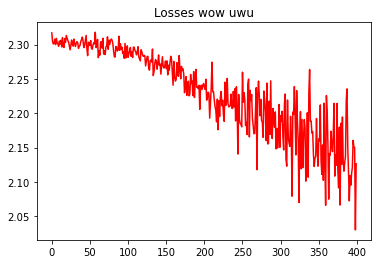

Iteration - 400 - loss 2.1385371685028076
Iteration - 401 - loss 2.1718766689300537
Iteration - 402 - loss 2.146547317504883
Iteration - 403 - loss 2.164247751235962
Iteration - 404 - loss 2.1161882877349854
Iteration - 405 - loss 2.156208038330078
Iteration - 406 - loss 2.0997681617736816
Iteration - 407 - loss 2.064863920211792
Iteration - 408 - loss 2.0590627193450928
Iteration - 409 - loss 2.0495717525482178
Iteration - 410 - loss 2.0883681774139404
Iteration - 411 - loss 2.1085147857666016
Iteration - 412 - loss 2.1262338161468506
Iteration - 413 - loss 2.089110851287842
Iteration - 414 - loss 2.121429681777954
Iteration - 415 - loss 2.1012110710144043
Iteration - 416 - loss 2.1305952072143555
Iteration - 417 - loss 2.1274640560150146
Iteration - 418 - loss 2.1221067905426025
Iteration - 419 - loss 2.092944383621216
Iteration - 420 - loss 2.1002845764160156
Iteration - 421 - loss 2.084750175476074
Iteration - 422 - loss 2.1099748611450195
Iteration - 423 - loss 2.1534459590911865


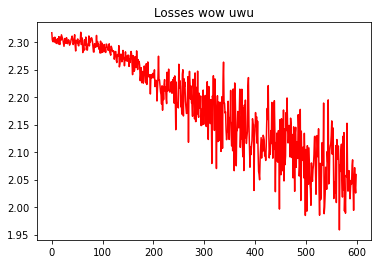

Iteration - 600 - loss 1.9546719789505005
Iteration - 601 - loss 2.053480863571167
Iteration - 602 - loss 2.0230276584625244
Iteration - 603 - loss 2.040428400039673
Iteration - 604 - loss 2.03164005279541
Iteration - 605 - loss 1.9855352640151978
Iteration - 606 - loss 2.0653069019317627
Iteration - 607 - loss 2.0203475952148438
Iteration - 608 - loss 2.167283296585083
Iteration - 609 - loss 2.104740619659424
Iteration - 610 - loss 2.126235008239746
Iteration - 611 - loss 2.162703037261963
Iteration - 612 - loss 2.0862317085266113
Iteration - 613 - loss 2.0932254791259766
Iteration - 614 - loss 1.9816405773162842
Iteration - 615 - loss 2.0674490928649902
Iteration - 616 - loss 1.995071530342102
Iteration - 617 - loss 1.9076896905899048
Iteration - 618 - loss 2.1150963306427
Iteration - 619 - loss 2.153191089630127
Iteration - 620 - loss 2.045576810836792
Iteration - 621 - loss 2.025614023208618
Iteration - 622 - loss 2.198824405670166
Iteration - 623 - loss 1.983812689781189
Iteration

Iteration - 797 - loss 2.0564513206481934
Iteration - 798 - loss 2.0171055793762207
Iteration - 799 - loss 2.061636447906494


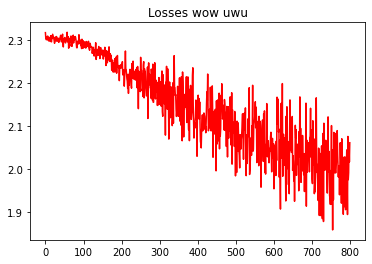

Iteration - 800 - loss 2.0577988624572754
Iteration - 801 - loss 2.0128371715545654
Iteration - 802 - loss 2.0047380924224854
Iteration - 803 - loss 1.9167652130126953
Iteration - 804 - loss 1.9507927894592285
Iteration - 805 - loss 2.0437965393066406
Iteration - 806 - loss 2.001692056655884
Iteration - 807 - loss 2.0505223274230957
Iteration - 808 - loss 1.930128812789917
Iteration - 809 - loss 1.9698091745376587
Iteration - 810 - loss 1.9135005474090576
Iteration - 811 - loss 2.0257911682128906
Iteration - 812 - loss 1.9707410335540771
Iteration - 813 - loss 2.0141496658325195
Iteration - 814 - loss 2.0119597911834717
Iteration - 815 - loss 1.9253442287445068
Iteration - 816 - loss 2.091604709625244
Iteration - 817 - loss 1.9202251434326172
Iteration - 818 - loss 2.004237651824951
Iteration - 819 - loss 2.052281618118286
Iteration - 820 - loss 2.1077682971954346
Iteration - 821 - loss 1.9799199104309082
Iteration - 822 - loss 1.8802462816238403
Iteration - 823 - loss 1.96269094944000

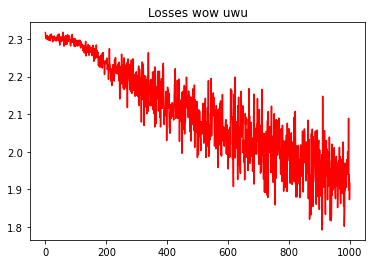

Iteration - 1000 - loss 2.060683012008667
Iteration - 1001 - loss 1.920945405960083
Iteration - 1002 - loss 1.9773733615875244
Iteration - 1003 - loss 1.8307607173919678
Iteration - 1004 - loss 1.937787413597107
Iteration - 1005 - loss 1.9361555576324463
Iteration - 1006 - loss 1.988361120223999
Iteration - 1007 - loss 1.9020251035690308
Iteration - 1008 - loss 1.9590837955474854
Iteration - 1009 - loss 1.8570500612258911
Iteration - 1010 - loss 1.9667409658432007
Iteration - 1011 - loss 1.8151026964187622
Iteration - 1012 - loss 1.911161184310913
Iteration - 1013 - loss 1.9681055545806885
Iteration - 1014 - loss 1.87603759765625
Iteration - 1015 - loss 1.9084327220916748
Iteration - 1016 - loss 1.849070429801941
Iteration - 1017 - loss 1.828908085823059
Iteration - 1018 - loss 1.9098185300827026
Iteration - 1019 - loss 1.8879075050354004
Iteration - 1020 - loss 1.9169386625289917
Iteration - 1021 - loss 1.901080846786499
Iteration - 1022 - loss 1.8529633283615112
Iteration - 1023 - lo

Iteration - 1195 - loss 1.8664271831512451
Iteration - 1196 - loss 1.8112818002700806
Iteration - 1197 - loss 1.820833683013916
Iteration - 1198 - loss 2.015491247177124
Iteration - 1199 - loss 1.803529977798462


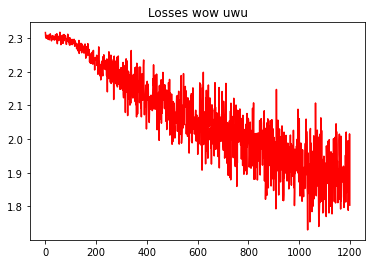

Iteration - 1200 - loss 1.840257167816162
Iteration - 1201 - loss 1.8583791255950928
Iteration - 1202 - loss 1.83612859249115
Iteration - 1203 - loss 1.8690550327301025
Iteration - 1204 - loss 2.0000367164611816
Iteration - 1205 - loss 1.8978291749954224
Iteration - 1206 - loss 2.007290840148926
Iteration - 1207 - loss 1.824761152267456
Iteration - 1208 - loss 1.9194878339767456
Iteration - 1209 - loss 1.8243473768234253
Iteration - 1210 - loss 1.7776861190795898
Iteration - 1211 - loss 1.8462347984313965
Iteration - 1212 - loss 1.9244946241378784
Iteration - 1213 - loss 1.8354263305664062
Iteration - 1214 - loss 2.0146658420562744
Iteration - 1215 - loss 1.890197992324829
Iteration - 1216 - loss 1.8155733346939087
Iteration - 1217 - loss 1.8201253414154053
Iteration - 1218 - loss 1.9783167839050293
Iteration - 1219 - loss 1.8674376010894775
Iteration - 1220 - loss 1.8602030277252197
Iteration - 1221 - loss 1.8371827602386475
Iteration - 1222 - loss 1.8696786165237427
Iteration - 1223 

Iteration - 1395 - loss 1.736968755722046
Iteration - 1396 - loss 1.821889042854309
Iteration - 1397 - loss 1.8269824981689453
Iteration - 1398 - loss 1.7980695962905884
Iteration - 1399 - loss 1.938993215560913


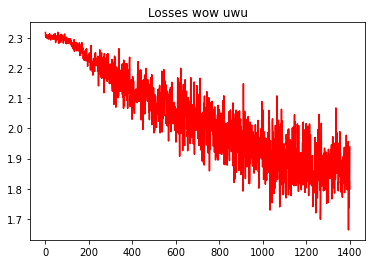

Iteration - 1400 - loss 1.8190699815750122
Iteration - 1401 - loss 1.8198258876800537
Iteration - 1402 - loss 1.7104625701904297
Iteration - 1403 - loss 1.9724178314208984
Iteration - 1404 - loss 1.9268059730529785
Iteration - 1405 - loss 1.8828543424606323
Iteration - 1406 - loss 1.902465581893921
Iteration - 1407 - loss 1.8234663009643555
Iteration - 1408 - loss 1.8929812908172607
Iteration - 1409 - loss 1.8964402675628662
Iteration - 1410 - loss 1.815891981124878
Iteration - 1411 - loss 1.9477806091308594
Iteration - 1412 - loss 1.9256478548049927
Iteration - 1413 - loss 1.9397040605545044
Iteration - 1414 - loss 1.9231315851211548
Iteration - 1415 - loss 1.7898716926574707
Iteration - 1416 - loss 1.780774712562561
Iteration - 1417 - loss 1.737745761871338
Iteration - 1418 - loss 1.9564203023910522
Iteration - 1419 - loss 1.7574650049209595
Iteration - 1420 - loss 1.8653055429458618
Iteration - 1421 - loss 1.769504189491272
Iteration - 1422 - loss 1.7908135652542114
Iteration - 1423

Iteration - 1595 - loss 1.7141799926757812
Iteration - 1596 - loss 1.8715540170669556
Iteration - 1597 - loss 1.8446379899978638
Iteration - 1598 - loss 1.9188491106033325
Iteration - 1599 - loss 1.7990416288375854


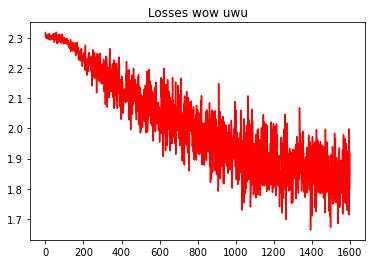

Iteration - 1600 - loss 1.7895739078521729
Iteration - 1601 - loss 1.8499019145965576
Iteration - 1602 - loss 1.8071118593215942
Iteration - 1603 - loss 1.8737975358963013
Iteration - 1604 - loss 1.9338922500610352
Iteration - 1605 - loss 1.6803122758865356
Iteration - 1606 - loss 1.8059451580047607
Iteration - 1607 - loss 1.8231406211853027
Iteration - 1608 - loss 1.9231271743774414
Iteration - 1609 - loss 1.9231412410736084
Iteration - 1610 - loss 1.985979676246643
Iteration - 1611 - loss 1.8256462812423706
Iteration - 1612 - loss 1.9313157796859741
Iteration - 1613 - loss 1.9053447246551514
Iteration - 1614 - loss 1.8955250978469849
Iteration - 1615 - loss 1.8621982336044312
Iteration - 1616 - loss 1.8973703384399414
Iteration - 1617 - loss 1.835626244544983
Iteration - 1618 - loss 1.7999191284179688
Iteration - 1619 - loss 1.8113774061203003
Iteration - 1620 - loss 1.8988981246948242
Iteration - 1621 - loss 1.8314900398254395
Iteration - 1622 - loss 1.8661925792694092
Iteration - 1

Iteration - 1795 - loss 1.6967171430587769
Iteration - 1796 - loss 1.9068949222564697
Iteration - 1797 - loss 1.8538775444030762
Iteration - 1798 - loss 1.8770813941955566
Iteration - 1799 - loss 1.7882217168807983


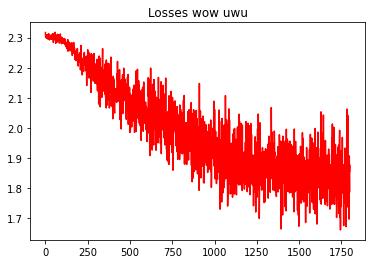

Iteration - 1800 - loss 1.8274520635604858
Iteration - 1801 - loss 1.850799322128296
Iteration - 1802 - loss 1.8156689405441284
Iteration - 1803 - loss 1.8066558837890625
Iteration - 1804 - loss 1.9286924600601196
Iteration - 1805 - loss 1.8054726123809814
Iteration - 1806 - loss 1.777916431427002
Iteration - 1807 - loss 1.7814470529556274
Iteration - 1808 - loss 1.843674659729004
Iteration - 1809 - loss 1.8397958278656006
Iteration - 1810 - loss 1.8223601579666138
Iteration - 1811 - loss 1.7607192993164062
Iteration - 1812 - loss 1.868121862411499
Iteration - 1813 - loss 1.8855862617492676
Iteration - 1814 - loss 1.785436749458313
Iteration - 1815 - loss 1.846129298210144
Iteration - 1816 - loss 1.8753286600112915
Iteration - 1817 - loss 1.9054148197174072
Iteration - 1818 - loss 1.8092488050460815
Iteration - 1819 - loss 1.8527107238769531
Iteration - 1820 - loss 1.7751816511154175
Iteration - 1821 - loss 1.8320616483688354
Iteration - 1822 - loss 1.9104609489440918
Iteration - 1823 

Iteration - 125 - loss 1.848142385482788
Iteration - 126 - loss 1.842938780784607
Iteration - 127 - loss 1.8842859268188477
Iteration - 128 - loss 1.681937336921692
Iteration - 129 - loss 1.8534621000289917
Iteration - 130 - loss 1.7278647422790527
Iteration - 131 - loss 1.8402764797210693
Iteration - 132 - loss 1.975454330444336
Iteration - 133 - loss 1.8527318239212036
Iteration - 134 - loss 1.7304065227508545
Iteration - 135 - loss 1.9375700950622559
Iteration - 136 - loss 1.7921446561813354
Iteration - 137 - loss 1.7995109558105469
Iteration - 138 - loss 1.8495581150054932
Iteration - 139 - loss 1.8546701669692993
Iteration - 140 - loss 1.8075203895568848
Iteration - 141 - loss 1.8543660640716553
Iteration - 142 - loss 1.8006919622421265
Iteration - 143 - loss 1.7239782810211182
Iteration - 144 - loss 1.7794805765151978
Iteration - 145 - loss 1.7337658405303955
Iteration - 146 - loss 1.862027883529663
Iteration - 147 - loss 1.700259804725647
Iteration - 148 - loss 1.794413447380066

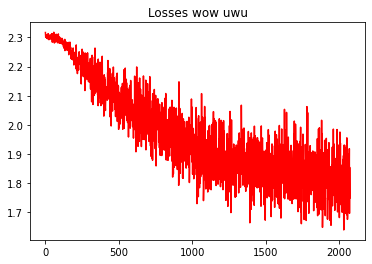

Iteration - 200 - loss 1.8103528022766113
Iteration - 201 - loss 1.8417614698410034
Iteration - 202 - loss 1.9854592084884644
Iteration - 203 - loss 1.7776886224746704
Iteration - 204 - loss 1.817064642906189
Iteration - 205 - loss 1.7655695676803589
Iteration - 206 - loss 1.8832807540893555
Iteration - 207 - loss 1.8139798641204834
Iteration - 208 - loss 1.7762271165847778
Iteration - 209 - loss 1.8037922382354736
Iteration - 210 - loss 1.794106364250183
Iteration - 211 - loss 1.8542230129241943
Iteration - 212 - loss 1.6775919198989868
Iteration - 213 - loss 1.7965049743652344
Iteration - 214 - loss 1.7938064336776733
Iteration - 215 - loss 1.7736786603927612
Iteration - 216 - loss 1.8614284992218018
Iteration - 217 - loss 1.7000634670257568
Iteration - 218 - loss 1.791340947151184
Iteration - 219 - loss 1.8767436742782593
Iteration - 220 - loss 1.8361740112304688
Iteration - 221 - loss 1.8861340284347534
Iteration - 222 - loss 1.786518931388855
Iteration - 223 - loss 1.7291308641433

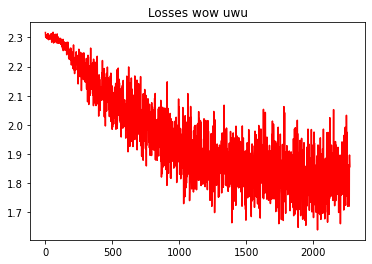

Iteration - 400 - loss 1.7796381711959839
Iteration - 401 - loss 1.7326672077178955
Iteration - 402 - loss 1.7329457998275757
Iteration - 403 - loss 1.8679054975509644
Iteration - 404 - loss 1.8164974451065063
Iteration - 405 - loss 1.866006851196289
Iteration - 406 - loss 1.7347221374511719
Iteration - 407 - loss 1.7986507415771484
Iteration - 408 - loss 1.7786052227020264
Iteration - 409 - loss 1.7982823848724365
Iteration - 410 - loss 1.920611023902893
Iteration - 411 - loss 1.7091457843780518
Iteration - 412 - loss 1.7256296873092651
Iteration - 413 - loss 1.754295825958252
Iteration - 414 - loss 1.6671535968780518
Iteration - 415 - loss 1.786731243133545
Iteration - 416 - loss 1.80807363986969
Iteration - 417 - loss 1.837286114692688
Iteration - 418 - loss 1.9159077405929565
Iteration - 419 - loss 1.7307770252227783
Iteration - 420 - loss 1.8447344303131104
Iteration - 421 - loss 1.927078127861023
Iteration - 422 - loss 1.8078511953353882
Iteration - 423 - loss 1.7902426719665527


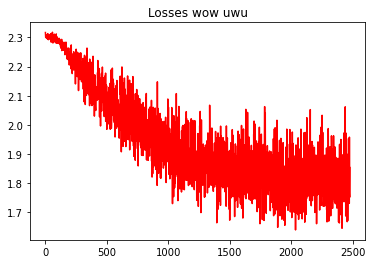

Iteration - 600 - loss 1.711705207824707
Iteration - 601 - loss 1.8527261018753052
Iteration - 602 - loss 1.65419602394104
Iteration - 603 - loss 1.887823224067688
Iteration - 604 - loss 1.7587295770645142
Iteration - 605 - loss 1.8649548292160034
Iteration - 606 - loss 1.697562575340271
Iteration - 607 - loss 1.7217004299163818
Iteration - 608 - loss 1.8446108102798462
Iteration - 609 - loss 1.8573557138442993
Iteration - 610 - loss 1.8557074069976807
Iteration - 611 - loss 1.8471572399139404
Iteration - 612 - loss 1.8443129062652588
Iteration - 613 - loss 1.8112727403640747
Iteration - 614 - loss 1.7564647197723389
Iteration - 615 - loss 1.8352502584457397
Iteration - 616 - loss 1.72468101978302
Iteration - 617 - loss 1.704073190689087
Iteration - 618 - loss 1.8425148725509644
Iteration - 619 - loss 1.8324967622756958
Iteration - 620 - loss 1.9000087976455688
Iteration - 621 - loss 1.8412803411483765
Iteration - 622 - loss 1.976854920387268
Iteration - 623 - loss 1.9031404256820679
I

KeyboardInterrupt: 

In [30]:
losses = []
for epoch in range(EPOCHS):
    print(f"Entering epoch {epoch}")
    perceiver.train()
    for batch_no, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        predictions = perceiver(features)
        
        loss = criterion(predictions, labels)
        optimizer.zero_grad()        
        loss.backward()
        
        optimizer.step()

        print(f'Iteration - {batch_no} - loss {loss.item()}')
        losses.append(loss.item())
        if batch_no % 200 == 199:
            plt.plot(losses, 'r-')
            plt.title('Losses wow uwu')
            plt.show()

In [ ]:
perceiver(dataset[0][0].to(device))

In [31]:
paramsAfter = [t.clone() for t in perceiver.parameters()]
equalCount = 0
equal_elemCount = 0
unequalCount = 0
unequal_elemCount = 0
totalDiff = 0
equal_names = []
unequal_names = []
named = list(perceiver.named_parameters())
for i, (paramInit, paramAfter) in enumerate(zip(paramsInit, paramsAfter)):
    if torch.equal(paramInit, paramAfter):
        equalCount += 1
        equal_elemCount += torch.numel(paramAfter)
        equal_names.append( named[i] )
    else:
        unequalCount += 1
        unequal_elemCount += torch.numel(paramAfter)
        totalDiff += torch.sum(torch.abs(paramAfter - paramInit))
        unequal_names.append( named[i] )

print(equalCount, unequalCount)
if unequalCount == 0:
    print('bro did nothing change??')
else:
    print(totalDiff / unequal_elemCount)
len(paramsAfter)
garbage = FMPreprocess()
print(equal_elemCount - torch.numel(garbage.encoding))
for name in map(lambda p: p[0], equal_names):
    print(name)
    
print('\n\n')
for name in map(lambda p: p[0], unequal_names):
    print(name)

1 229
tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)
0
preprocess.encoding



preprocess.conv0.weight
perceiver.q_in
perceiver.q_out
perceiver.encoder.block.0.q_norm.weight
perceiver.encoder.block.0.q_norm.bias
perceiver.encoder.block.0.kv_norm.weight
perceiver.encoder.block.0.kv_norm.bias
perceiver.encoder.block.0.mlp_norm.weight
perceiver.encoder.block.0.mlp_norm.bias
perceiver.encoder.block.0.attn.q_proj_weight
perceiver.encoder.block.0.attn.k_proj_weight
perceiver.encoder.block.0.attn.v_proj_weight
perceiver.encoder.block.0.attn.in_proj_bias
perceiver.encoder.block.0.attn.out_proj.weight
perceiver.encoder.block.0.attn.out_proj.bias
perceiver.encoder.block.0.mlp.lin_in.weight
perceiver.encoder.block.0.mlp.lin_in.bias
perceiver.encoder.block.0.mlp.lin_out.weight
perceiver.encoder.block.0.mlp.lin_out.bias
perceiver.encoder.block.1.in_norm.weight
perceiver.encoder.block.1.in_norm.bias
perceiver.encoder.block.1.mlp_norm.weight
perceiver.encoder.block.1.mlp_norm.bias
perceiver.e

In [32]:
testloader = DataLoader(testset, batch_size=1)
acc_count = 0
count = 0
perceiver.eval()
for i, (feature, label) in enumerate(testloader):
    feature = feature.to(device)
    label = label.to(device)
    prediction = perceiver(feature)
    prediction = torch.argmax(prediction)
    
    if prediction == label:
        acc_count += 1
        
    count += 1
    
    if i == 500:
        break
        
print(acc_count / count)

0.49700598802395207
